###### Probabalistic Demonstration of A Bayesian Changepoint analysis, Inncluding a rudimentary correlation and forecasting solutions

##### Goals:
###### Take a number of input well logs, from a geoligically similar basin and analyse them by identifying changepoints and data trends that will be used to interprete property changes and characterize the subsurface. Follow by simulating a drilling campaign

##### Outline: 
###### Volve Dataset will be used as a test case of the analysis, 5 wells have been drilled in the north sea Volve field offshore of southern Norway. This notebook will try to forcast the probability of property changes from a hypothetical drilling campaign, while drilling. Simulated by incremetally adding data to the analysis from a known well.

###### Some background info... and nomenclature. I've decided to use the vernacular 'CompariTEE' and 'CompariTOR' to describe the Unknown and known wells, if only to capitalize on the neumonic *Prior/Tor* it really could have gone either way.




###### Comparitor ('priors') wells: 15-9: F1, F1A, F1B, F1C, F11B, F11T2 
###### Comparitee (investigation) wells: 15-9-F11A 






###### adam jones 05.07.23

In [2]:
'''Loading dependencies''' 
import sys
sys.path.append('..\\..\\src')
import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt
import welly
import pandas as pd
import scipy.stats as stats

#Collections of self built methods
import cp_comparitor as cp_Comp
import change_point_tools as cp_Tools
import well_tools as wtool

# This is testing module
import test_func as tst

In [5]:
# OS well path
#path = 'C:\\Users\\ada55080\\git\different_bayes\\volve_well_data\\'
path ='..\\..\\data\\raw\\volve_well_data\\'

##### Loading Wells into memory, Volve wells 15-9: F1, F1A, F1B, F1C, F11B, F11



In [6]:
# These are pretty well groomed but lack some spatial data (TVD, Lat/Long, etc...)

f1 = welly.Well.from_las(path + '15_9-F-1\\15_9_F1_complete.las')
f1A = welly.Well.from_las(path + '15_9-F-1A\\15_9-F-1A.las')
f1B = welly.Well.from_las(path + '15_9-F-1B\\15_9-F-1B.las')
f1C = welly.Well.from_las(path + '15_9-F-1C\\15_9-F-1C.las')
f11A = welly.Well.from_las(path + '15_9-F-11A\\15_9-F-11A.las')
f11B = welly.Well.from_las(path + '15_9-F-11B\\15_9-F11B.las')

In [7]:
# Building Welly Project object... These are complete, but ungroomed, so they contain outliers and null data.

volve_15_9_complete = welly.Project.from_las([path + '15_9-F-1\\15_9_F1_complete.las',
                                    path + '15_9-F-1A\\15_9_F1A_complete.las',
                                    path + '15_9-F-1B\\15_9_F1B_complete.las',
                                    path + '15_9-F-1C\\15_9_F1C_complete.las',  
                                    path + '15_9-F-11A\\15_9_F11A_complete.las',
                                    path + '15_9-F-11T2\\15_9_F11T2_complete.las',
                                    ])

#volve_15_9 wells that are groomed (much like the cell above)
# volve_15_9 = welly.Project.from_las([path + '15_9-F-1\\15_9_F1_complete.las',
#                                     path + '15_9-F-1A\\15_9-F-1A.las',
#                                     path + '15_9-F-1B\\15_9-F-1B.las',
#                                     path + '15_9-F-1C\\15_9-F-1C.las',
#                                     path + '15_9-F-11A\\15_9-F-11A.las',
#                                     path + '15_9-F-11T2\\15_9_F11T2_complete.las',
#                                     ])


6it [00:20,  3.38s/it]


c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\welly\curve.py:470: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if self.df.index.is_numeric() and not self.df.index.empty:


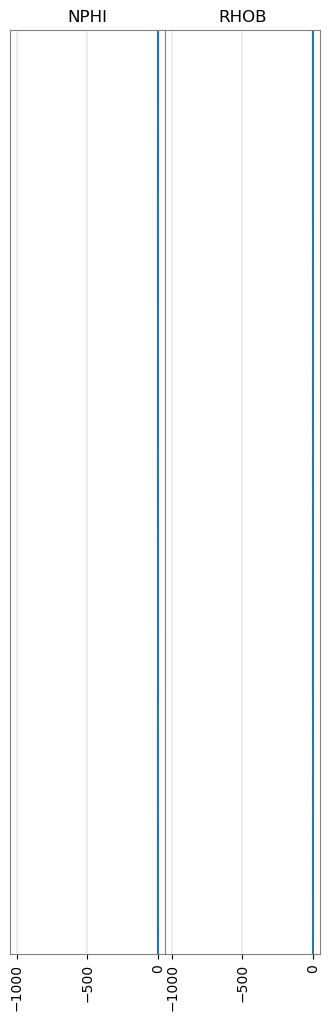

In [8]:
volve_15_9_complete[0].plot(tracks=['NPHI','RHOB'], extents=(2620,3590))
#volve_15_9_complete[0].plot??

###### The following dictionaries are "global" place holder variables. yes i know, global is bad

In [10]:

#Rolling average parameters

window = 30
periods = 3

#setting global variables for the ruptures PELT parameters pen and min_size 
RHOB_glob_pen = 0.5
RHOB_glob_min = 10

NPHI_glob_pen = 0.1
NPHI_glob_min = 10

GR_glob_pen = 1300
GR_glob_min = 10


#string label varables'
dataGR = "GR"
dataRHOB = "RHOB"
dataNPHI = "NPHI"

#Well names lists for automation
_wellnames = ['df_f1','df_f1A', 'df_f1B', 'df_f1C', 'df_f11A', 'df_f11T2']
_wells = [f1, f1A, f1B, f1C, f11A, f11B]
_log_list = ['NPHI','RHOB','GR','DT','PEF']
_log_list_GR = ['GR']
_log_list_nodt = ['NPHI','RHOB','GR','PEF']


#Dictionaries for well extents in meters below surface

_logname_extent_min = {'f1': 2620 ,'f1A' : 2620, 'f1B' : 3100 , 'f1C': 3100 , 'f11A' : 2600 , 'f11B': 3200 }
_logname_extent_max = {'f1': 3590 ,'f1A' : 3600, 'f1B' : 3400 , 'f1C': 4100 , 'f11A' : 3700 , 'f11B': 4550 }
_log_extent_min = {0 : 2620, 1 : 3100 , 2: 3100 , 3 : 2600 , 4: 3200 }
_log_extent_max = {0: 3600, 1 : 3400 , 2: 4100 , 3 : 3700 , 4: 4550 }


##### Loading Volve Well logs... These logs do not have any spacial awareness so everthing is relative to the Measured Depth
######  in the borehole future implementations will need some 3D awareness to be convincing, as these particular wells are controlled for depth and are clearly in the same basin they can work for this illustration

In [11]:
# Writing well log values to dataframe, index is MD(measured depth)
df_f1 = _wells[0].df(_log_list)
df_f1A = _wells[1].df(_log_list)
df_f1B = _wells[2].df(_log_list)
df_f1C = _wells[3].df(_log_list)
df_f11A = _wells[4].df(_log_list)
df_f11B = _wells[5].df(_log_list)

df_f1clip = df_f1[2620:3590]
'''Un-Comment for Building dataframes with Rolling Averages'''
data_f1A = wtool.compute_all_rolling_avg(df_f1A, window=30, periods=3)
data_f1B = wtool.compute_all_rolling_avg(df_f1B, window=30, periods=3)
# data_f1C = wtool.compute_all_rolling_avg(df_f1C, window=30, periods=3)
data_f11A = wtool.compute_all_rolling_avg(df_f11A, window=30, periods=3)
# data_f11B = wtool.compute_all_rolling_avg(df_f11B, window=30, periods=3)


c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\welly\curve.py:470: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if self.df.index.is_numeric() and not self.df.index.empty:
c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\welly\curve.py:470: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if self.df.index.is_numeric() and not self.df.index.empty:
c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\welly\curve.py:470: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if self.df.index.is_numeric() and not self.df.index.empty:
c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\welly\curve.py:470: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if self.df.index.is_numeric() and not self.df.index.empty:
c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\welly\cu

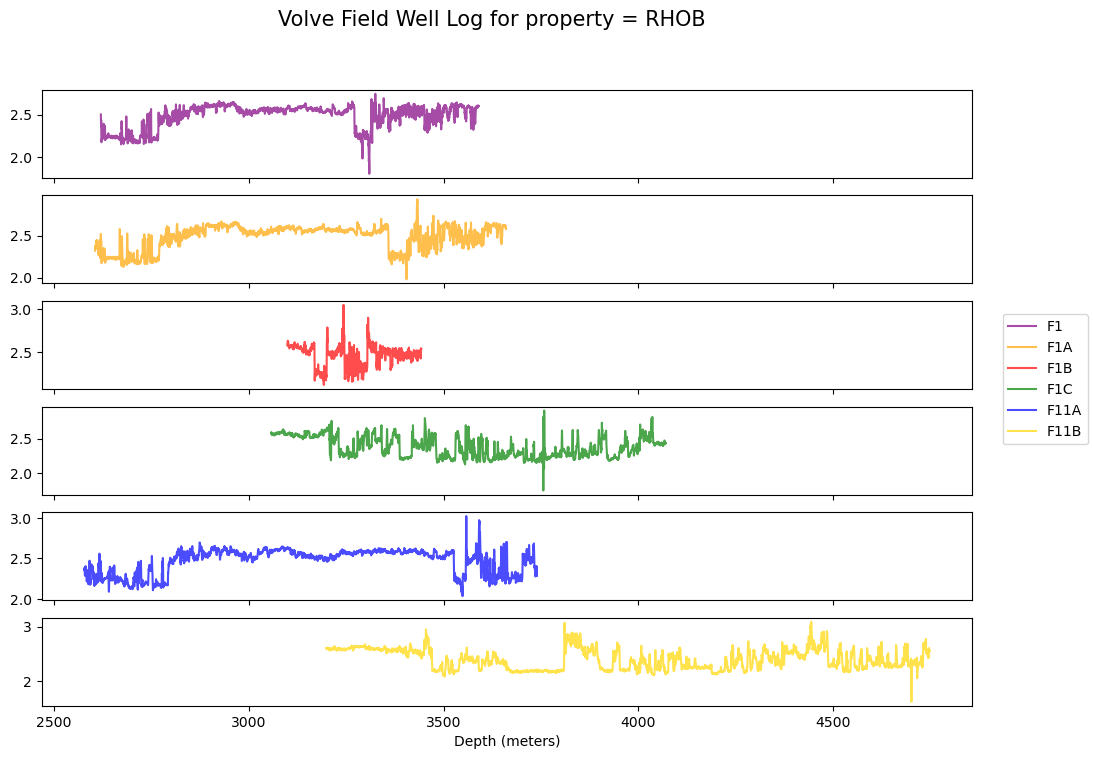

In [19]:
'''Ploting to check everything is importing correctly'''
log= ['RHOB']

fig, ax = plt.subplots(6, figsize=(12,8), sharex=True)
ax[0].plot(df_f1clip[log], label='F1', color= 'purple', alpha=0.7)
ax[1].plot(df_f1A[log], label='F1A', color='orange', alpha=0.7)
ax[2].plot(df_f1B[log], label='F1B', color='red', alpha=0.7)
ax[3].plot(df_f1C[log], label='F1C', color='green', alpha=0.7)
ax[4].plot(df_f11A[log], label='F11A', color='blue', alpha=0.7)
ax[5].plot(df_f11B[log], label='F11B', color='gold', alpha=0.7)
fig.suptitle('Volve Field Well Log for property = '+str(log[0]), fontsize=15)
ax[5].set_xlabel('Depth (meters)', fontsize=10)
fig.legend(loc='center right')

##### Testing cell that searches for changepoint probabilitiesfor the input well logs

In [9]:
'''Testing Bayesian changepoint method, and populating well dataframe'''
# data_f1A['Roll_Avg_GR'] = wtool.fill_out_data_ends(data_f1A['Roll_Avg_GR'].values)

# data_f1A['Roll_Avg_GR'] = wtool.replace_nans(data_f1A['Roll_Avg_GR'].values, method='linear_interpolation', window_size=200)

# data_f1A['CPprob_GR'] = cp_Tools.bayes_offline_split(data_f1A['Roll_Avg_GR'].values, sequence_length=1000)


# data_f1A['GR'] = wtool.fill_out_data_ends(data_f1A['GR'].values)

# data_f1A['GR'] = wtool.replace_nans(data_f1A['GR'].values, method='linear_interpolation', window_size=200)

# data_f1A['CPprob_GRraw'] = cp_Tools.bayes_offline_split(data_f1A['GR'].values, sequence_length=1000)

'Testing Bayesian changepoint method, and populating well dataframe'

In [10]:
''' This is a helper function will groom the ends (by holding values) and remove NaN's of an
    incomplete dataset and perform a Bayesian changepoint search.

    results of the search will be added to another row of the dataframe.

    Really should be building a well 'object' that holds this data along with the
    trends and correlation to other wells, but for now it is a dataframe...

'''

def df_add_CP_Prob(df, log_dict=[], label='CP_Prob_', nan_method='local_average', window_size=200, segment_length=1000, **kwargs):
    
     #Keyword Args assingment
    _prior = kwargs.get('prior') # choices are "const", "geometric", "neg_binomial"
    _method = kwargs.get('method')  # choices are 'gauss', 'ifm' or 'full_cov'
    _engine = kwargs.get('engine')  # choices are "numpy" or "numba"

    #Argument Defaults
    if _method == None:
        _method = "full_cov"
    if _prior == None:
        _prior = "const"
    if _engine == None:
        _engine ="numba"
    
    #Fill ends of incomplete df, replace NaN's with parameter method, and changepoint search with parameter segment splits
    for log in log_dict:
        print(log+' finding changepoints')
        labl = label+log
        df[log] = wtool.fill_out_data_ends(df[log].values)

        df[log] = wtool.replace_nans(df[log].values, method=nan_method, window_size=window_size)
        
        df[labl] = cp_Tools.bayes_offline_split(df[log].values, segment_length=segment_length, method=_method, prior=_prior, engine=_engine)

        

In [11]:
''' ! ! ! AUCHTUNG ! ! !  ***** This cell will take a bit of time to compute, *****  

time for coffee break? or just take your eyes off the screen.

for me each took about 8 min with sequence_length=1000 I have them individually commented for convenience
to reduce the compute time, reduce the _segment_length variable as this will lighten the computational load
'''

_segment_length = 100 # the method will split the dataset into equal chunks to compute their probabilities separately, mostly for computational efficiency
_window_size = 100 # when filling missing data with the 'local_average' method, this is the parameter fed into np.convolve to impute the missing vals

df_add_CP_Prob(df_f1clip, log_dict=_log_list_nodt, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length)

df_add_CP_Prob(df_f1A, log_dict=_log_list_nodt, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length)

df_add_CP_Prob(df_f1B, log_dict=_log_list_nodt, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length)

df_add_CP_Prob(df_f1C, log_dict=_log_list_nodt, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length)

df_add_CP_Prob(df_f11A, log_dict=_log_list_nodt, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length)

df_add_CP_Prob(df_f11B, log_dict=_log_list_nodt, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length)

#df_CP_Prob(df_f1A, log_dict=['GR'], label='CP_Prob_', method='local_average', window_size=_window_size, segment_length=_segment_length)




#### template ##### df_CP_Prob(df, log_dict=[], label='CP_Prob_', method='local_average', window_size=_window_size, segement_length=_segment_length)






NPHI finding changepoints
method- full_cov, prior- const, engine- numba
Segmenting into 100


C:\Users\ada55080\AppData\Local\Temp\ipykernel_18952\4216310806.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[log] = wtool.fill_out_data_ends(df[log].values)
C:\Users\ada55080\AppData\Local\Temp\ipykernel_18952\4216310806.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[log] = wtool.replace_nans(df[log].values, method=nan_method, window_size=window_size)


/nRHOB finding changepoints600: 9700 of 9700
method- full_cov, prior- const, engine- numba
Segmenting into 100


C:\Users\ada55080\AppData\Local\Temp\ipykernel_18952\4216310806.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[labl] = cp_Tools.bayes_offline_split(df[log].values, segment_length=segment_length, method=_method, prior=_prior, engine=_engine)
C:\Users\ada55080\AppData\Local\Temp\ipykernel_18952\4216310806.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[log] = wtool.fill_out_data_ends(df[log].values)
C:\Users\ada55080\AppData\Local\Temp\ipykernel_18952\4216310806.py:32: SettingWithCopyWarning:

/nGR finding changepoints 9600: 9700 of 9700
method- full_cov, prior- const, engine- numba
Segmenting into 100


C:\Users\ada55080\AppData\Local\Temp\ipykernel_18952\4216310806.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[labl] = cp_Tools.bayes_offline_split(df[log].values, segment_length=segment_length, method=_method, prior=_prior, engine=_engine)
C:\Users\ada55080\AppData\Local\Temp\ipykernel_18952\4216310806.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[log] = wtool.fill_out_data_ends(df[log].values)
C:\Users\ada55080\AppData\Local\Temp\ipykernel_18952\4216310806.py:32: SettingWithCopyWarning:

/nPEF finding changepoints9600: 9700 of 9700
method- full_cov, prior- const, engine- numba
Segmenting into 100


C:\Users\ada55080\AppData\Local\Temp\ipykernel_18952\4216310806.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[labl] = cp_Tools.bayes_offline_split(df[log].values, segment_length=segment_length, method=_method, prior=_prior, engine=_engine)
C:\Users\ada55080\AppData\Local\Temp\ipykernel_18952\4216310806.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[log] = wtool.fill_out_data_ends(df[log].values)
C:\Users\ada55080\AppData\Local\Temp\ipykernel_18952\4216310806.py:32: SettingWithCopyWarning:

/nNPHI finding changepoints600: 9700 of 9700
method- full_cov, prior- const, engine- numba
Segmenting into 100


C:\Users\ada55080\AppData\Local\Temp\ipykernel_18952\4216310806.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[labl] = cp_Tools.bayes_offline_split(df[log].values, segment_length=segment_length, method=_method, prior=_prior, engine=_engine)


/nRHOB finding changepoints35300: 35361 of 35361
method- full_cov, prior- const, engine- numba
Segmenting into 100
/nGR finding changepointsm 35300: 35361 of 35361
method- full_cov, prior- const, engine- numba
Segmenting into 100
/nPEF finding changepoints 35300: 35361 of 35361
method- full_cov, prior- const, engine- numba
Segmenting into 100
/nNPHI finding changepoints35300: 35361 of 35361
method- full_cov, prior- const, engine- numba
Segmenting into 100
/nRHOB finding changepoints33100: 33191 of 33191
method- full_cov, prior- const, engine- numba
Segmenting into 100
/nGR finding changepointsm 33100: 33191 of 33191
method- full_cov, prior- const, engine- numba
Segmenting into 100
/nPEF finding changepoints 33100: 33191 of 33191
method- full_cov, prior- const, engine- numba
Segmenting into 100
/nNPHI finding changepoints33100: 33191 of 33191
method- full_cov, prior- const, engine- numba
Segmenting into 100
/nRHOB finding changepoints39400: 39481 of 39481
method- full_cov, prior- const,

<Figure size 1000x300 with 0 Axes>

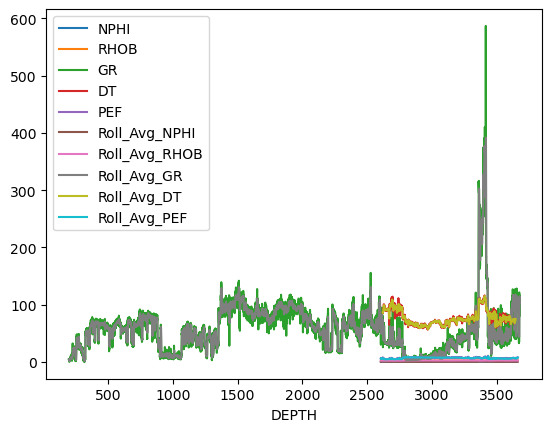

In [144]:
'''This Cell is built to check for completeness by graphing the raw data on top of the change point 
probabilities'''
plt.figure(figsize=(10,3))
# cp_list = [ 'CP_Prob_GR', 'CP_Prob_NPHI', 'CP_Prob_PEF', 'CP_Prob_RHOB']
# cp_GR = ['CP_Prob_GR', 'GR']

# #df_f1A[cp_GR].plot(alpha=0.8)
data_f1A.plot()
#plt.plot(data_f1A['GR']/df_f1A['GR'].max(), alpha=0.7, label='RAW data, normalized')
#plt.plot(data_f1A['CP_Prob_GR'], alpha=0.6, label='Change Point Probability')
# #df_f1C.plot()
plt.legend(loc='upper left')

##### The Question of noise reduction, for example by comuting the rolling average of a dataset.
###### a rolling average is often used to deconvolute the data so that changepoints are less obscured ba them, but it seems that the Offline Bayesian search function is quite robustly finding changepoints without this step. 
###### Arguably, it even does a better job with RAW data, this simple comparison is meant to demonstrate that.

GR finding changepoints
method- full_cov, prior- const, engine- numba
Segmenting into 300
/nRoll_Avg_GR finding changepoints35361 of 35361
method- full_cov, prior- const, engine- numba
Segmenting into 300
/nmpleted segment 118 from 35100: 35361 of 35361

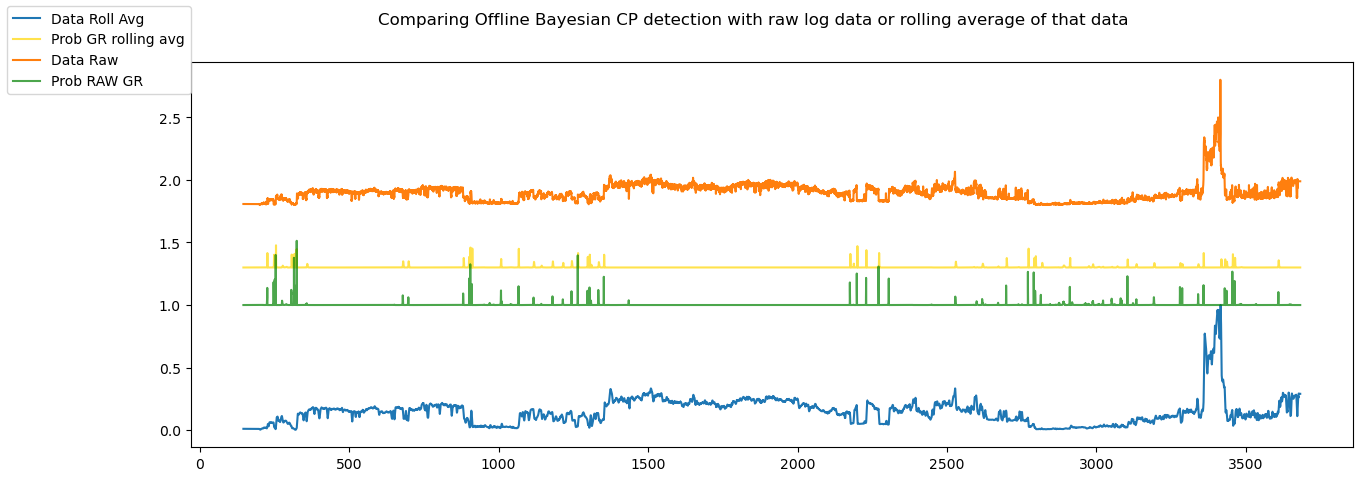

In [146]:
''' This Shows that performing the change point analysis on a log and a rolling average of the log produce comparable results, if not slightly muted for the Avg.'''
#data_f1A = wtool.compute_all_rolling_avg(df_f1A, window=30, periods=3)

df_add_CP_Prob(data_f1A, log_dict=['GR', 'Roll_Avg_GR' ], label='CP_Prob_', nan_method='local_average', window_size=200, segment_length=300)

fig, ax = plt.subplots(1, figsize=(15,5))

#ax[0].plot(data_f1A['CP_Prob_Roll_Avg_GR']-data_f1A['CP_Prob_GR'])
ax.plot(data_f1A['Roll_Avg_GR']/data_f1A['Roll_Avg_GR'].max(), label='Data Roll Avg')
ax.plot(data_f1A['CP_Prob_Roll_Avg_GR']+1.3, label='Prob GR rolling avg', alpha=0.7, color='gold')

ax.plot(data_f1A['GR']/data_f1A['GR'].max()+1.8, label='Data Raw')
ax.plot(data_f1A['CP_Prob_GR']+1, label='Prob RAW GR', color='green', alpha=0.7)

fig.suptitle('Comparing Offline Bayesian CP detection with raw log data or rolling average of that data')
fig.legend(loc=('upper left'));


In [43]:
_log_ = 'GR'
_prob_ = 'CP_Prob_GR'

_log_list_nodt = ['NPHI','RHOB','GR','PEF']
_prob_list_nodt = ['CP_Prob_NPHI','CP_Prob_RHOB','CP_Prob_GR','CP_Prob_PEF']

_wellnames_ = ['f1','f1A', 'f1B', 'f1C', 'f11A', 'f11B']
_well_df_ = {'f1': df_f1clip, 'f1A': df_f1A, 'f1B': df_f1B, 'f1C': df_f1C, 'f11A': df_f11A, 'f11B' : df_f11B}

peak_height= 0.06 #Probability threshold to qualify as a distinct changepoint

for well in _wellnames_:
    for _log_choice, _prob_choice in zip(_log_list_nodt, _prob_list_nodt):

        globals()[well+'_'+_log_choice+'_CPstats'] = cp_Comp.changepoint_stat(_well_df_[well][_log_choice][_logname_extent_min[well]:_logname_extent_max[well]].to_numpy(), 
                                                    _well_df_[well][_prob_choice][_logname_extent_min[well]:_logname_extent_max[well]].to_numpy(), height=peak_height, stat_margin=0)

        print(well+ '_'+ _log_choice + ' complete')


#globals()[prefix + str(var_num) + suffix] =    

7 Change points: [1286 2656 4682 4843 5956 6993 7254]
f1_NPHI complete
0 Change points: []
f1_RHOB complete
16 Change points: [1085 1492 1677 1721 1953 1955 1962 2367 2842 2847 2850 4284 4685 5943
 6996 7063]
f1_GR complete
0 Change points: []
f1_PEF complete
11 Change points: [ 477  487 1944 1965 2696 4834 6589 7208 7377 8645 8703]
f1A_NPHI complete
0 Change points: []
f1A_RHOB complete
16 Change points: [ 778 1507 1702 1939 2431 2909 4413 4415 4611 4835 6594 7201 7383 8094
 8347 8423]
f1A_GR complete
0 Change points: []
f1A_PEF complete
5 Change points: [   8  418  426  682 2039]
f1B_NPHI complete
0 Change points: []
f1B_RHOB complete
6 Change points: [ 417  681 1642 1684 1884 1942]
f1B_GR complete
0 Change points: []
f1B_PEF complete
17 Change points: [ 424  842 1292 2395 2406 2537 3504 3801 4308 4555 4582 4612 6556 6581
 7317 7397 8656]
f1C_NPHI complete
0 Change points: []
f1C_RHOB complete
16 Change points: [ 426 1050 1130 1305 1514 1516 1700 1783 4793 5003 5132 5388 6046 6647
 7

array([[ 0.00000000e+00,  4.70658988e+01,  4.53464000e+01,
         1.19479060e+01,  3.48329961e-01,  3.24360405e+01],
       [ 8.50000000e+01,  4.29010333e+01,  3.79595501e+01,
         8.51013033e+00,  7.85203219e-01,  3.38711963e+01],
       [ 1.09000000e+02,  3.47129500e+01,  3.42010000e+01,
         1.32968018e+00,  1.83707428e-01,  3.31514369e+01],
       [ 1.27000000e+02,  3.28543297e+01,  3.26754000e+01,
         1.89058887e+00, -3.03355105e-03,  3.33988521e+01],
       [ 4.87000000e+02,  3.89646146e+01,  3.26750000e+01,
         1.26305239e+01, -4.35532523e-02,  5.19434838e+01],
       [ 1.08400000e+03,  3.70077385e+01,  3.13545000e+01,
         1.33702322e+01, -1.74078983e-01,  4.52764902e+01],
       [ 1.18000000e+03,  5.28237924e+01,  5.94256001e+01,
         1.37238867e+01, -8.36778277e-02,  5.71750394e+01],
       [ 1.28500000e+03,  3.13166246e+01,  2.96166000e+01,
         7.26272677e+00,  4.60931504e-02,  2.65690301e+01],
       [ 1.49200000e+03,  1.40483370e+01,  1.391

##### Finding breakpoints and trends for Volve input, ONLY UNIVARIATE LOGS for this example:
###### Changepoints are identified by SciPy find_peaks of a offline bayesian changepoint probability curve. Using sdt-python (implementation of Fearnhead 2006) 
###### Trend values are the mean for the data sections between breakpoints. (will soon include a more complete comparitor vector [CP, AvgL, AvgR, \sigma L, \sigma R, \alpha \beta \sigma L, \alpha \beta \sigma R])


In [175]:
_log_choice = 'GR'
_prob_choice = 'CP_Prob_GR'

#f1A_GRmu, f1A_GRbp = cp_Comp.prob_piecewise_linearRegress(df_f1A[_log_choice][_logname_extent_min['f1A']:_logname_extent_max['f1A']].to_numpy(), 
#                                                          df_f1A[_prob_choice][_logname_extent_min['f1A']:_logname_extent_max['f1A']].to_numpy(), height=0.3)

#stats, bkps = cp_Comp.changepoint_stat(data, prob, height=0.1)
#prob_piecewise_linearRegress(data, prob)


f1_GRmu, f1_GRbp = cp_Comp.changepoint_stat(df_f1clip[_log_choice][_logname_extent_min['f1']:_logname_extent_max['f1']].to_numpy(), 
                                                           df_f1clip[_prob_choice][_logname_extent_min['f1']:_logname_extent_max['f1']].to_numpy(), height=0.2, stat_margin=0)

f1A_GRmu, f1A_GRbp = cp_Comp.changepoint_stat(df_f1A[_log_choice][_logname_extent_min['f1A']:_logname_extent_max['f1A']].to_numpy(), 
                                                          df_f1A[_prob_choice][_logname_extent_min['f1A']:_logname_extent_max['f1A']].to_numpy(), height=0.2, stat_margin=0)

f1B_GRmu, f1B_GRbp = cp_Comp.changepoint_stat(df_f1B[_log_choice][_logname_extent_min['f1B']:_logname_extent_max['f1B']].to_numpy(), 
                                                          df_f1B[_prob_choice][_logname_extent_min['f1B']:_logname_extent_max['f1B']].to_numpy(), height=0.2, stat_margin=0)

f1C_GRmu, f1C_GRbp = cp_Comp.changepoint_stat(df_f1C[_log_choice][_logname_extent_min['f1C']:_logname_extent_max['f1C']].to_numpy(), 
                                                          df_f1C[_prob_choice][_logname_extent_min['f1C']:_logname_extent_max['f1C']].to_numpy(), height=0.2, stat_margin=0)

f11A_GRmu, f11A_GRbp = cp_Comp.changepoint_stat(df_f11A[_log_choice][_logname_extent_min['f11A']:_logname_extent_max['f11A']].to_numpy(), 
                                                           df_f11A[_prob_choice][_logname_extent_min['f11A']:_logname_extent_max['f11A']].to_numpy(), height=0.2, stat_margin=0)
                                                          
f11B_GRmu, f11B_GRbp = cp_Comp.changepoint_stat(df_f11B[_log_choice][_logname_extent_min['f11B']:_logname_extent_max['f11B']].to_numpy(), 
                                                          df_f11B[_prob_choice][_logname_extent_min['f11B']:_logname_extent_max['f11B']].to_numpy(), height=0.2, stat_margin=0)

44 Change points: [ 488  761 1180 1285 1492 1676 1721 1732 1907 1912 1953 1955 1962 2367
 2654 2661 2667 2673 2842 2847 2850 3351 3354 3359 3362 3370 4152 4159
 4284 4308 4544 4581 4685 4839 5261 5943 6344 6502 6938 7063 8315 8326
 9483 9494]
41 Change points: [   7   88  107  596  779 1194 1309 1506 1701 1748 1750 1754 1969 1978
 1981 2431 2591 2593 2909 3431 3434 3439 3514 3532 3542 4022 4413 4416
 4611 4650 4835 5134 5722 6594 7202 7380 7958 8093 8152 8347 8423]
10 Change points: [   8  417  681 1013 1382 1555 1642 1684 1884 1943]
37 Change points: [ 426  549 1049 1135 1306 1514 1516 1574 1580 1583 1585 1590 1700 1766
 2393 3183 3588 3722 3797 4448 4487 4793 5003 5132 5387 6046 6646 7539
 7555 8008 8158 8163 8165 8168 9034 9337 9356]
77 Change points: [   26    39   239   396   436   632   800  1025  1418  1533  1944  2193
  2239  2242  2247  2254  2256  2409  2557  2561  2567  3007  3147  3158
  3248  3404  3539  3766  3769  3782  3795  3797  3801  3805  3808  3813
  3815  3960  39

In [20]:
f1A_GRmu, np.where(np.isnan(f1A_GRmu_S))

#f1A_GRbp_S, f1A_GRbp

(array([  0.        ,  48.40375926,  39.48665887,  31.91699922,
         36.18174334,  38.78979201,  14.05503247,   7.87397235,
          4.90525001,   4.88      ,   3.45715228,   3.74306667,
          3.57      ,   3.17100001,   3.69768   ,   3.4379    ,
          3.58723333,   3.68083333,   4.7583625 ,   4.13393862,
          4.165675  ,   4.18705556,   4.50748571,   4.79803846,
          4.84505   ,   4.70065   ,   5.11017126,  12.13793461,
          8.72604639,   7.47996667,   7.15244   ,   8.132735  ,
          8.30616212,  11.43636875,  10.39503332,  10.9284    ,
         12.31833185,  13.03516098,  13.66664135,  12.53019997,
         13.2307927 ,   8.88365192,  24.58769632,  29.57743329,
         31.00003248,  28.15279995,  43.55825356,  25.94024934,
         61.75935122,  53.64663595, 275.96245103, 150.23550077,
         44.47766786,  19.59769211,  54.27345829,  46.53253334,
         44.75140001]),
 (array([], dtype=int64), array([], dtype=int64)))

In [234]:
_log_choice = 'RHOB'
_prob_choice = 'CP_Prob_RHOB'


#prob_piecewise_linearRegress(data, prob)
f1_RHOBmu, f1_RHOBbp = cp_Comp.prob_piecewise_linearRegress(df_f1clip[_log_choice][_logname_extent_min['f1']:_logname_extent_max['f1']].to_numpy(), 
                                                          df_f1clip[_prob_choice][_logname_extent_min['f1']:_logname_extent_max['f1']].to_numpy())
f1A_RHOBmu, f1A_RHOBbp = cp_Comp.prob_piecewise_linearRegress(df_f1A[_log_choice][_logname_extent_min['f1A']:_logname_extent_max['f1A']].to_numpy(), 
                                                              df_f1A[_prob_choice][_logname_extent_min['f1A']:_logname_extent_max['f1A']].to_numpy())
f1B_RHOBmu, f1B_RHOBbp = cp_Comp.prob_piecewise_linearRegress(df_f1B[_log_choice][_logname_extent_min['f1B']:_logname_extent_max['f1B']].to_numpy(), 
                                                              df_f1B[_prob_choice][_logname_extent_min['f1B']:_logname_extent_max['f1B']].to_numpy())
f1C_RHOBmu, f1C_RHOBbp = cp_Comp.prob_piecewise_linearRegress(df_f1C[_log_choice][_logname_extent_min['f1C']:_logname_extent_max['f1C']].to_numpy(), 
                                                              df_f1C[_prob_choice][_logname_extent_min['f1C']:_logname_extent_max['f1C']].to_numpy())
f11A_RHOBmu, f11A_RHOBbp = cp_Comp.prob_piecewise_linearRegress(df_f11A[_log_choice][_logname_extent_min['f11A']:_logname_extent_max['f11A']].to_numpy(), 
                                                              df_f11A[_prob_choice][_logname_extent_min['f11A']:_logname_extent_max['f11A']].to_numpy())
f11B_RHOBmu, f11B_RHOBbp = cp_Comp.prob_piecewise_linearRegress(df_f11B[_log_choice][_logname_extent_min['f11B']:_logname_extent_max['f11B']].to_numpy(), 
                                                              df_f11B[_prob_choice][_logname_extent_min['f11B']:_logname_extent_max['f11B']].to_numpy())

1 [0.]
[0.]
1 [0.]
[0.]
1 [0.]
[0.]
1 [0.]
[0.]
1 [0.]
[0.]
1 [0.]
[0.]


In [188]:
_log_choice = 'PEF'
_prob_choice = 'CP_Prob_PEF'


#prob_piecewise_linearRegress(data, prob)
f1_PEFmu, f1_PEFbp = cp_Comp.prob_piecewise_linearRegress(df_f1clip[_log_choice][_logname_extent_min['f1']:_logname_extent_max['f1']].to_numpy(), 
                                                          df_f1clip[_prob_choice][_logname_extent_min['f1']:_logname_extent_max['f1']].to_numpy())

f1A_PEFmu, f1A_PEFbp = cp_Comp.prob_piecewise_linearRegress(df_f1A[_log_choice][_logname_extent_min['f1A']:_logname_extent_max['f1A']].to_numpy(), 
                                                            df_f1A[_prob_choice][_logname_extent_min['f1A']:_logname_extent_max['f1A']].to_numpy())
f1B_PEFmu, f1B_PEFbp = cp_Comp.prob_piecewise_linearRegress(df_f1B[_log_choice][_logname_extent_min['f1B']:_logname_extent_max['f1B']].to_numpy(), 
                                                            df_f1B[_prob_choice][_logname_extent_min['f1B']:_logname_extent_max['f1B']].to_numpy())
f1C_PEFmu, f1C_PEFbp = cp_Comp.prob_piecewise_linearRegress(df_f1C[_log_choice][_logname_extent_min['f1C']:_logname_extent_max['f1C']].to_numpy(), 
                                                            df_f1C[_prob_choice][_logname_extent_min['f1C']:_logname_extent_max['f1C']].to_numpy())
f11A_PEFmu, f11A_PEFbp = cp_Comp.prob_piecewise_linearRegress(df_f11A[_log_choice][_logname_extent_min['f11A']:_logname_extent_max['f11A']].to_numpy(), 
                                                            df_f11A[_prob_choice][_logname_extent_min['f11A']:_logname_extent_max['f11A']].to_numpy())
f11B_PEFmu, f11B_PEFbp = cp_Comp.prob_piecewise_linearRegress(df_f11B[_log_choice][_logname_extent_min['f11B']:_logname_extent_max['f11B']].to_numpy(), 
                                                            df_f11B[_prob_choice][_logname_extent_min['f11B']:_logname_extent_max['f11B']].to_numpy())

1 [0.]
[0.]
1 [0.]
[0.]
1 [0.]
[0.]
3 [   0. 6550. 6581.]
[0.         6.06482206 9.7491258 ]
3 [   0. 9565. 9945.]
[0.         7.54510455 7.68002895]
3 [    0.  7513. 12858.]
[0.         6.06805737 5.28502675]


In [187]:
_log_choice = 'NPHI'
_prob_choice = 'CP_Prob_NPHI'


#prob_piecewise_linearRegress(data, prob)
f1_NPHImu, f1_NPHIbp = cp_Comp.prob_piecewise_linearRegress(df_f1clip[_log_choice][_logname_extent_min['f1']:_logname_extent_max['f1']].to_numpy(), 
                                                          df_f1clip[_prob_choice][_logname_extent_min['f1']:_logname_extent_max['f1']].to_numpy())

f1A_NPHImu, f1A_NPHIbp = cp_Comp.prob_piecewise_linearRegress(df_f1A[_log_choice][_logname_extent_min['f1A']:_logname_extent_max['f1A']].to_numpy(),
                                                              df_f1A[_prob_choice][_logname_extent_min['f1A']:_logname_extent_max['f1A']].to_numpy())
f1B_NPHImu, f1B_NPHIbp = cp_Comp.prob_piecewise_linearRegress(df_f1B[_log_choice][_logname_extent_min['f1B']:_logname_extent_max['f1B']].to_numpy(),
                                                              df_f1B[_prob_choice][_logname_extent_min['f1B']:_logname_extent_max['f1B']].to_numpy())
f1C_NPHImu, f1C_NPHIbp = cp_Comp.prob_piecewise_linearRegress(df_f1C[_log_choice][_logname_extent_min['f1C']:_logname_extent_max['f1C']].to_numpy(),
                                                              df_f1C[_prob_choice][_logname_extent_min['f1C']:_logname_extent_max['f1C']].to_numpy())
f11A_NPHImu, f11A_NPHIbp = cp_Comp.prob_piecewise_linearRegress(df_f11A[_log_choice][_logname_extent_min['f11A']:_logname_extent_max['f11A']].to_numpy(),
                                                              df_f11A[_prob_choice][_logname_extent_min['f11A']:_logname_extent_max['f11A']].to_numpy())
f11B_NPHImu, f11B_NPHIbp = cp_Comp.prob_piecewise_linearRegress(df_f11B[_log_choice][_logname_extent_min['f11B']:_logname_extent_max['f11B']].to_numpy(),
                                                              df_f11B[_prob_choice][_logname_extent_min['f11B']:_logname_extent_max['f11B']].to_numpy())

246 [   0.   94.  189.  296.  484.  597.  652.  656.  689.  794.  897. 1064.
 1085. 1177. 1192. 1197. 1235. 1248. 1257. 1286. 1481. 1495. 1592. 1652.
 1677. 1686. 1768. 1790. 1839. 1853. 1889. 1936. 1949. 1991. 2020. 2065.
 2067. 2087. 2116. 2128. 2137. 2167. 2170. 2256. 2265. 2271. 2281. 2285.
 2297. 2363. 2365. 2383. 2389. 2440. 2454. 2462. 2485. 2495. 2566. 2577.
 2590. 2596. 2656. 2767. 2784. 2793. 2798. 2849. 2851. 2857. 2880. 2945.
 2977. 2991. 2997. 3049. 3073. 3077. 3080. 3094. 3165. 3267. 3292. 3341.
 3352. 3355. 3359. 3362. 3366. 3374. 3384. 3389. 3454. 3467. 3480. 3540.
 3548. 3572. 3577. 3675. 3996. 4058. 4073. 4079. 4089. 4162. 4185. 4193.
 4284. 4340. 4357. 4364. 4383. 4439. 4454. 4479. 4488. 4493. 4545. 4569.
 4580. 4682. 4751. 4761. 4843. 4974. 4986. 5048. 5057. 5093. 5151. 5153.
 5182. 5184. 5261. 5385. 5396. 5492. 5563. 5569. 5586. 5592. 5638. 5678.
 5691. 5790. 5893. 5956. 6095. 6271. 6293. 6343. 6377. 6379. 6466. 6475.
 6888. 6993. 7024. 7077. 7163. 7169. 7186. 7234

In [189]:
_log_choice = 'DT'
_prob_choice = 'CP_Prob_DT'


#prob_piecewise_linearRegress(data, prob)
f1_DTmu, f1_DTbp = cp_Comp.prob_piecewise_linearRegress(df_f1clip[_log_choice][_logname_extent_min['f1']:_logname_extent_max['f1']].to_numpy(), 
                                                          df_f1clip[_prob_choice][_logname_extent_min['f1']:_logname_extent_max['f1']].to_numpy())

f1A_DTmu, f1A_DTbp = cp_Comp.prob_piecewise_linearRegress(df_f1A[_log_choice][_logname_extent_min['f1A']:_logname_extent_max['f1A']].to_numpy(),
                                                          df_f1A[_prob_choice][_logname_extent_min['f1A']:_logname_extent_max['f1A']].to_numpy())
f1B_DTmu, f1B_DTbp = cp_Comp.prob_piecewise_linearRegress(df_f1B[_log_choice][_logname_extent_min['f1B']:_logname_extent_max['f1B']].to_numpy(),
                                                          df_f1B[_prob_choice][_logname_extent_min['f1B']:_logname_extent_max['f1B']].to_numpy())
#f1C_DTmu, f1C_DTbp = cp_Comp.prob_piecewise_linearRegress(df_f1C[_log_choice][_logname_extent_min['f1C']:_logname_extent_max['f1C']].to_numpy(),
#                                                          df_f1C[_prob_choice][_logname_extent_min['f1C']:_logname_extent_max['f1C']].to_numpy())
f11A_DTmu, f11A_DTbp = cp_Comp.prob_piecewise_linearRegress(df_f11A[_log_choice][_logname_extent_min['f11A']:_logname_extent_max['f11A']].to_numpy(),
                                                          df_f11A[_prob_choice][_logname_extent_min['f11A']:_logname_extent_max['f11A']].to_numpy())
#f11B_DTmu, f11B_DTbp = cp_Comp.prob_piecewise_linearRegress(df_f11B[_log_choice][_logname_extent_min['f11B']:_logname_extent_max['f11B']].to_numpy(),
#                                                          df_f11B[_prob_choice][_logname_extent_min['f11B']:_logname_extent_max['f11B']].to_numpy())


1 [0.]
[0.]
1 [0.]
[0.]
1 [0.]
[0.]
1 [0.]
[0.]


##### This section runs a very permissible cosine similarity inference, so there is a lot of noise in the result.

Finding a more decerning algorythm is a topic of research on it's own but for this example it illustrates the point.
 

In [131]:
# Stacking breakpoint/trends from seach function for input into the correlation function.

# cpf1_RHOB = np.vstack((f1_RHOBbp, f1_RHOBmu))
# cpf1A_RHOB = np.vstack((f1A_RHOBbp, f1A_RHOBmu))
# cpf1B_RHOB = np.vstack((f1B_RHOBbp, f1B_RHOBmu))
# cpf1C_RHOB = np.vstack((f1C_RHOBbp, f1C_RHOBmu))
# cpf11A_RHOB = np.vstack((f11A_RHOBbp, f11A_RHOBmu))
# cpf11B_RHOB = np.vstack((f11B_RHOBbp, f11B_RHOBmu))

# cpf1_PEF = np.vstack((f1_PEFbp, f1_PEFmu))
# cpf1A_PEF = np.vstack((f1A_PEFbp, f1A_PEFmu))
# cpf1B_PEF = np.vstack((f1B_PEFbp, f1B_PEFmu))
# cpf1C_PEF = np.vstack((f1C_PEFbp, f1C_PEFmu))
# cpf11A_PEF = np.vstack((f11A_PEFbp, f11A_PEFmu))
# cpf11B_PEF = np.vstack((f11B_PEFbp, f11B_PEFmu))

# cpf1_NPHI = np.vstack((f1_NPHIbp, f1_NPHImu))
# cpf1A_NPHI = np.vstack((f1A_NPHIbp, f1A_NPHImu))
# cpf1B_NPHI = np.vstack((f1B_NPHIbp, f1B_NPHImu))
# cpf1C_NPHI = np.vstack((f1C_NPHIbp, f1C_NPHImu))
# cpf11A_NPHI = np.vstack((f11A_NPHIbp, f11A_NPHImu))
# cpf11B_NPHI = np.vstack((f11B_NPHIbp, f11B_NPHImu))

# cpf1_GR = np.vstack((f1_GRbp, f1_GRmu))
# cpf1A_GR = np.vstack((f1A_GRbp, f1A_GRmu))
# cpf1B_GR = np.vstack((f1B_GRbp, f1B_GRmu))
# cpf1C_GR = np.vstack((f1C_GRbp, f1C_GRmu))
# cpf11A_GR = np.vstack((f11A_GRbp, f11A_GRmu))
# cpf11B_GR = np.vstack((f11B_GRbp, f11B_GRmu))


In [30]:
# Identified tops from the well 15-9 -F11A to compare against the output

f11A_FM = {0:'Norland GP FM', 1:'Ty FM', 2:'Ekofisk FM', 3:'Hod FM', 4:'Draupne FM', 5:'Heather FM', 6:'Heather FM (Sand)', 7:'Hugin FM', 8:'Sleipner FM'}
f11A_color = {0:'r', 1:'g', 2:'purple', 3:'orange', 4:'yellow', 5:'grey', 6:'black', 7:'pink', 8:'blue'}
f11A_tops = np.array([2600, 2624,2794.5,3118,3525.8,3574.9,3585.2,3594.6,3702])

vectors = []

In [19]:
def prob_cpCorrelation(cpComparitee, cpComparitor, **kwargs):
    
    '''Correlation engine for changepoint associations:
    takes in two vectors (m x n) of changepoints/trends. One compariTEE who is compared to the compariTOR.
    
    Relative changepoint (vector[0]) and corresponding trend values (vector[1:]) 
    
    
    Uses a kwarg to choose the geometric comparitor operation:
    
    operator= 
    'cosine'
    'euclidean'
    'theta'
    'triangle'
    'sector'
    'mag'


    Builds output of change points that correspond to all remaining changepoints after the matching input vector. 
    '''

    #for key, value in kwargs.items():
        #print(f"{key}: {value}")

    tee = cpCompConstructor(cpComparitee)
    tor = cpCompConstructor(cpComparitor)
    
    opFunc_dict = {'cosine':Cosine, 'euclidean': Euclidean, 'theta': Theta, 'triangle': Triangle, 'sector': Sector, 'magnitude': Magnitude_Difference} 
    _operator = kwargs.get('operator')
    
    _threshold = kwargs.get('thresh')

    _df = kwargs.get('df')
    _log = kwargs.get('log')



    operator = opFunc_dict[_operator]

    QumeProb = np.array([])
    k = 1
    '''    
    cos_thresh = 0.999999 # match is 1.0 (very tight threshhold, all reasonalble values are very close to 1.0)
    euclidean_thresh = 0.1 # match is near zero
    theta_thresh = 0.1745 # match is .1745
    triangle_thresh = 0.2 # match is near zero
    sector_thresh = 0.1 # match is near zero
    '''
    
    for i in range(1,len(tee)):
        for j in range(1,len(tor)):
            #print('iter')
            #print(tor[j][1],tor[j][2])
            #print(tee[i][1],tee[i][2])
            #if tor[j][1] == tee[i][1] and tor[j][2] == tee[i][2]:
            if operator(tor[j][1:], tee[i][1:]) >= _threshold:
                print('*****MATCH' + str(operator(tor[j][1:], tee[i][1:])))
                probAdd = _df[_log][tee[i][0]:].to_numpy()
                #print(tor[i][1],tor[i][2])
                #print(tee[j][1],tee[j][2])    
                QumeProb = add_timelines(QumeProb, probAdd, start1=0, start2=int(tor[j][0]))    
    #unique, counts = np.unique(CumulativeProb, return_counts=True)
    
    V = QumeProb 
    
    return V

def add_timelines(timeline1, timeline2, start1, start2):
    # Determine the length and ending indices of the timelines
    len1 = len(timeline1)
    len2 = len(timeline2)
    end1 = start1 + len1
    end2 = start2 + len2
    
    # Determine the length of the combined timeline
    combined_length = max(end1, end2)
    
    # Create an empty combined timeline
    combined_timeline = np.zeros(combined_length)
    
    # Add the first timeline to the combined timeline
    combined_timeline[start1:end1] += timeline1
    
    # Add the second timeline to the combined timeline
    combined_timeline[start2:end2] += timeline2
    
    return combined_timeline


def cpCompConstructor(cpWell):
    '''Creates a ChangePoint input 'length' of Rows by 3 columns matrix 
    that will be used to compare sequentially to another changepoint matix'''
    
    cpBLNK = cpWell
    
    cpCompWellX = np.empty(3*len(cpBLNK[0])).reshape(len(cpBLNK[0]),3)
    
    #Setting special case Zero offset (Start of well) condition, to initial values
    cpCompWellX[0] = np.array((cpBLNK[0,0],cpBLNK[1,0],cpBLNK[1,0]))
    #for loop follows through with the rest of the ChangePTS
    for i in range(1,len(cpBLNK[0])):

        cpCompWellX[i] = np.array((cpBLNK[0,i],cpBLNK[1,i-1],cpBLNK[1,i]))
    return cpCompWellX #Returns matix

def Cosine(comparitee_vector, comparitor_vector):
    dot_product = np.dot(comparitee_vector, comparitor_vector.T)
    denominator = (np.linalg.norm(comparitee_vector) * np.linalg.norm(comparitor_vector))
    return dot_product/denominator

    # Euclidean Distance - Multi dimentional pythagorean eq.
def Euclidean(comparitee_vector, comparitor_vector):
    vec1 = comparitee_vector.copy()
    vec2 = comparitor_vector.copy()
    if len(vec1)<len(vec2): vec1,vec2 = vec2,vec1
    #vec2 = np.resize(vec2,(vec1.shape[0],vec1.shape[1]))
    return np.linalg.norm(vec1-vec2)

# Adaptation of Cosine similarity
def Theta(comparitee_vector, comparitor_vector):
    return np.arccos(Cosine(comparitee_vector, comparitor_vector)) + np.radians(10)

#Triangle Area Similarity – Sector Area Similarity.
# 1. Angle
# 2. Euclidean Distance between vectors
# 3. Magnitude of vectors
def Triangle(comparitee_vector, comparitor_vector):
    theta = np.radians(Theta(comparitee_vector, comparitor_vector))
    return ((np.linalg.norm(comparitee_vector) * np.linalg.norm(comparitor_vector)) * np.sin(theta))/2

#Magnitude Difference
def Magnitude_Difference(vec1, vec2):
    return abs((np.linalg.norm(vec1) - np.linalg.norm(vec2)))
    
    
#Sector Area Similarity    
def Sector(comparitee_vector, comparitor_vector):
    ED = Euclidean(comparitee_vector, comparitor_vector)
    MD = Magnitude_Difference(comparitee_vector, comparitor_vector)
    theta = Theta(comparitee_vector, comparitor_vector)
    return np.pi * (ED + MD)**2 * theta/360

def normalize_array(arr, low_clip, high_clip): 
    '''created through CHATGPT-4
    text input:

    build a python function that normalizes a numpy 
    array to values between zero and one as inputs takes in an 
    array to normalize, and two clipping percentage parameters 
    one for the high end and one for the low end'''

    # Calculate the lower and upper percentile values
    low_value = np.percentile(arr, low_clip)
    high_value = np.percentile(arr, 100 - high_clip)
    
    # Clip the array values based on the percentiles
    clipped_arr = np.clip(arr, low_value, high_value)
    
    # Normalize the clipped array to values between zero and one
    normalized_arr = (clipped_arr - low_value) / (high_value - low_value)
    
    return normalized_arr

def combine_vector_and_matrix(vector, matrix, column):
    # Check if the column value is valid
    #if column < 0 or column > matrix.shape[1]:
    #    raise ValueError("Invalid column value")

    # Calculate the dimensions of the new matrix
    num_rows = matrix.shape[0] + 1
    num_cols = max(matrix.shape[1], column + len(vector))

    # Create a new matrix with the desired dimensions, filled with zeros
    combined_matrix = np.zeros((num_rows, num_cols))

    # Copy the original matrix to the new matrix
    combined_matrix[:-1, :matrix.shape[1]] = matrix

    # Copy the vector to the new matrix
    combined_matrix[-1, column:column + len(vector)] = vector

    return combined_matrix

In [229]:
operator = 'cosine'
thresh = 0.4

f1_11A_RHOB_prob = prob_cpCorrelation(cpf1_RHOB, cpf11A_RHOB, operator=operator, thresh = thresh, df=df_f1clip, log='CP_Prob_RHOB')

f1A_11A_RHOB_prob = prob_cpCorrelation(cpf1A_RHOB, cpf11A_RHOB, operator=operator, thresh = thresh, df=df_f1A, log='CP_Prob_RHOB')
f1C_11A_RHOB_prob = prob_cpCorrelation(cpf1C_RHOB, cpf11A_RHOB, operator=operator, thresh = thresh, df=df_f1C, log='CP_Prob_RHOB')
f1B_11A_RHOB_prob = prob_cpCorrelation(cpf1B_RHOB, cpf11A_RHOB, operator=operator, thresh = thresh, df=df_f1B, log='CP_Prob_RHOB')
f11B_11A_RHOB_prob = prob_cpCorrelation(cpf1B_RHOB, cpf11A_RHOB, operator=operator, thresh = thresh, df=df_f11B, log='CP_Prob_RHOB')

In [91]:
def prob_cpCorr(cpComparitee, cpComparitor, **kwargs):
    
    '''Correlation engine for changepoint associations:
    takes in two matrix (m  x n) of changepoints/trends. One compariTEE who is compared to the compariTOR.
    
    Relative changepoint (vector[0]) and corresponding trend values (vector[1:]) 
    
    
    Uses a kwarg to choose the geometric comparitor operation:
    
    operator= 
    'cosine'
    'euclidean'
    'theta'
    'triangle'
    'sector'
    'mag'


    Builds output of change points that correspond to all remaining changepoints after the matching input vector. 
    '''

    #for key, value in kwargs.items():
        #print(f"{key}: {value}")

    tee = cpComparitee
    tor = cpComparitor
    
    opFunc_dict = {'cosine':Cosine, 'euclidean': Euclidean, 'theta': Theta, 'triangle': Triangle, 'sector': Sector, 'magnitude': Magnitude_Difference} 
    _operator = kwargs.get('operator')
    
    _threshold = kwargs.get('thresh')

    _df = kwargs.get('df')
    _log = kwargs.get('log')



    operator = opFunc_dict[_operator]

    QumeProb = np.array(([0],[0]))
    #k = 1
    '''    
    cos_thresh = 0.999999 # match is 1.0 (very tight threshhold, all reasonalble values are very close to 1.0)
    euclidean_thresh = 0.1 # match is near zero
    theta_thresh = 0.1745 # match is .1745
    triangle_thresh = 0.2 # match is near zero
    sector_thresh = 0.1 # match is near zero
    '''
    
    for i in range(1,len(tee)):
        for j in range(1,len(tor)):
            idx = int(tee[j][0])
            teeTee = np.concatenate((tee[i-1][1:],tee[i][1:]))
            torTor = np.concatenate((tor[j-1][1:],tor[j][1:]))
            #print('iter')
            #print(tor[j][1],tor[j][2])
            #print(tee[i][1],tee[i][2])
            #if tor[j][1] == tee[i][1] and tor[j][2] == tee[i][2]:
            if operator(torTor, teeTee) >= _threshold:
                jump = int(tee[i][0]) 
                print('*MATCH at Tor depth '+ str(idx)+ ' to Tee depth '+str(jump)+ ' with ' + operator+ ' value ' + str(operator(torTor, teeTee)))
                probAdd = _df[_log][jump:].to_numpy()
                #print(tor[i][1],tor[i][2])
                #print(tee[j][1],tee[j][2])
                QumeProb = combine_vector_and_matrix(probAdd, QumeProb, jump)
                print('adding at '+str(jump))     
    #unique, counts = np.unique(CumulativeProb, return_counts=True)
    
    V = QumeProb.sum(axis=0)
    
    return V

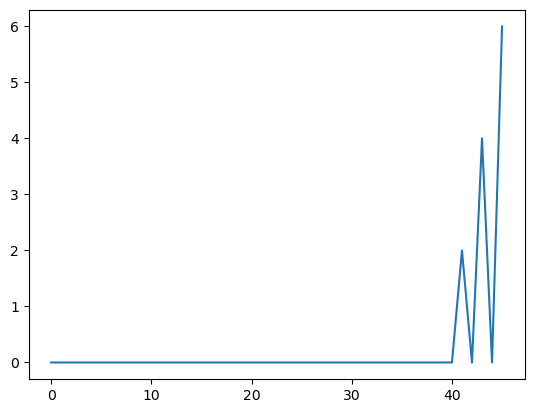

In [84]:
foo = np.array(([0],[0]))
bar = np.array([0,2,0,4,0,6])

combi = combine_vector_and_matrix(bar, foo, 40)


plt.plot(combi.sum(axis=0))


In [92]:
operator = 'cosine'
thresh = 0.998

f1_11A_GR_prob = prob_cpCorr(f11A_GR_CPstats[0], f1_GR_CPstats[0], operator=operator, thresh = thresh, df=df_f1clip, log='CP_Prob_GR')
#f1B_11A_GRcorr = cp_Comp.cpCorrelation(cpf1B_GR, cpf11A_GR, operator=operator, thresh = thresh)
f1A_11A_GR_prob = prob_cpCorr(f11A_GR_CPstats[0], f1A_GR_CPstats[0], operator=operator, thresh = thresh, df=df_f1A, log='CP_Prob_GR')
f1C_11A_GR_prob = prob_cpCorr(f11A_GR_CPstats[0], f1C_GR_CPstats[0], operator=operator, thresh = thresh, df=df_f1C, log='CP_Prob_GR')
f1B_11A_GR_prob = prob_cpCorr(f11A_GR_CPstats[0], f1B_GR_CPstats[0], operator=operator, thresh = thresh, df=df_f1B, log='CP_Prob_GR')
f11B_11A_GR_prob = prob_cpCorr(f11A_GR_CPstats[0], f11B_GR_CPstats[0], operator=operator, thresh = thresh, df=df_f11B, log='CP_Prob_GR')

# f1_11A_GR_prob = prob_cpCorrelation(cpf1_GR, cpf11A_GR, operator=operator, thresh = thresh, df=df_f1clip, log='CP_Prob_GR')
# #f1B_11A_GRcorr = cp_Comp.cpCorrelation(cpf1B_GR, cpf11A_GR, operator=operator, thresh = thresh)
# f1A_11A_GR_prob = prob_cpCorrelation(cpf1A_GR, cpf11A_GR, operator=operator, thresh = thresh, df=df_f1A, log='CP_Prob_GR')
# f1C_11A_GR_prob = prob_cpCorrelation(cpf1C_GR, cpf11A_GR, operator=operator, thresh = thresh, df=df_f1C, log='CP_Prob_GR')
# f1B_11A_GR_prob = prob_cpCorrelation(cpf1B_GR, cpf11A_GR, operator=operator, thresh = thresh, df=df_f1B, log='CP_Prob_GR')
# f11B_11A_GR_prob = prob_cpCorrelation(cpf1B_GR, cpf11A_GR, operator=operator, thresh = thresh, df=df_f11B, log='CP_Prob_GR')

*MATCH 1944 1944 0.9983804233030124
adding at 1944
*MATCH 3538 3538 0.9984220156303146
adding at 3538


In [88]:
_log_ = 'GR'
_prob_ = 'CP_Prob_GR'

_log_list_nodt = ['NPHI','RHOB','GR','PEF']
_prob_list_nodt = ['CP_Prob_NPHI','CP_Prob_RHOB','CP_Prob_GR','CP_Prob_PEF']

_wellnames_ = ['f1','f1A', 'f1B', 'f1C', 'f11A', 'f11B']
_well_df_ = {'f1': df_f1clip, 'f1A': df_f1A, 'f1B': df_f1B, 'f1C': df_f1C, 'f11A': df_f11A, 'f11B' : df_f11B}

#peak_height= 0.06 #Probability threshold to qualify as a distinct changepoint

operator = 'cosine'
thresh = 0.999


comparitee = 'f11A'

Tor = []

for well in _wellnames_:
    for _df_, _prob_, _log_ in zip(_well_df_,_prob_list_nodt,_log_list_nodt):
        Tee = globals()[comparitee+'_'+_log_+'_CPstats'] 
        Tor = globals()[well+'_'+_log_+'_CPstats']
    
        globals()[well+comparitee+_log_+'_prob'] = prob_cpCorr(Tee[0], Tor[0], operator=operator, thresh = thresh, df=_df_, log=_prob_)

    #f1_11A_GR_prob = prob_cpCorr(f11A_GRmu, f1_GRmu, operator=operator, thresh = thresh, df=df_f1clip, log='CP_Prob_GR')

*MATCH 111.0000000000000002


TypeError: string indices must be integers

In [209]:
operator = 'cosine'
thresh = 0.999999999

#f1B_11A_GRcorr = cp_Comp.cpCorrelation(cpf1B_GR, cpf11A_GR, operator=operator, thresh = thresh)
f1_11A_NPHI_prob = prob_cpCorrelation(cpf1_NPHI, cpf11A_NPHI, operator=operator, thresh = thresh, df=df_f1clip, log='CP_Prob_NPHI')

f1A_11A_NPHI_prob = prob_cpCorrelation(cpf1A_NPHI, cpf11A_NPHI, operator=operator, thresh = thresh, df=df_f1A, log='CP_Prob_NPHI')
f1C_11A_NPHI_prob = prob_cpCorrelation(cpf1C_NPHI, cpf11A_NPHI, operator=operator, thresh = thresh, df=df_f1C, log='CP_Prob_NPHI')
f1B_11A_NPHI_prob = prob_cpCorrelation(cpf1B_NPHI, cpf11A_NPHI, operator=operator, thresh = thresh, df=df_f1B, log='CP_Prob_NPHI')
f11B_11A_NPHI_prob = prob_cpCorrelation(cpf1B_NPHI, cpf11A_NPHI, operator=operator, thresh = thresh, df=df_f11B, log='CP_Prob_NPHI')

*****MATCH1.0
*****MATCH0.9999999999909622
*****MATCH0.9999999998717378
*****MATCH0.9999999994834101
*****MATCH0.9999999999893489
*****MATCH0.999999999625312
*****MATCH0.9999999992562796
*****MATCH0.9999999998946923
*****MATCH0.9999999999861459
*****MATCH0.9999999995032053
*****MATCH0.9999999990359748
*****MATCH0.9999999998805975
*****MATCH0.9999999996374078
*****MATCH0.9999999999903286
*****MATCH0.9999999991862171
*****MATCH0.9999999999819148
*****MATCH0.9999999994156544
*****MATCH0.9999999998852723
*****MATCH0.9999999998839874
*****MATCH1.0
*****MATCH0.9999999998941537
*****MATCH0.9999999999679474
*****MATCH0.999999999914019
*****MATCH0.9999999999513965
*****MATCH0.9999999997682925
*****MATCH0.9999999994034072
*****MATCH0.9999999999691174
*****MATCH0.9999999999858038
*****MATCH1.0
*****MATCH0.9999999993667423
*****MATCH0.9999999998378575
*****MATCH0.9999999999977247
*****MATCH1.0
*****MATCH0.9999999999918677
*****MATCH0.999999999833292
*****MATCH0.9999999999396928
*****MATCH0.9999999

In [212]:
operator = 'cosine'
thresh = 0.999999999
f1_11A_PEF_prob = prob_cpCorrelation(cpf1_PEF, cpf11A_PEF, operator=operator, thresh = thresh, df=df_f1clip, log='CP_Prob_PEF')
#f1B_11A_GRcorr = cp_Comp.cpCorrelation(cpf1B_GR, cpf11A_GR, operator=operator, thresh = thresh)
f1A_11A_PEF_prob = prob_cpCorrelation(cpf1A_PEF, cpf11A_PEF, operator=operator, thresh = thresh, df=df_f1A, log='CP_Prob_PEF')
f1C_11A_PEF_prob = prob_cpCorrelation(cpf1C_PEF, cpf11A_PEF, operator=operator, thresh = thresh, df=df_f1C, log='CP_Prob_PEF')
f1B_11A_PEF_prob = prob_cpCorrelation(cpf1B_PEF, cpf11A_PEF, operator=operator, thresh = thresh, df=df_f1B, log='CP_Prob_PEF')
f11B_11A_PEF_prob = prob_cpCorrelation(cpf1B_PEF, cpf11A_PEF, operator=operator, thresh = thresh, df=df_f11B, log='CP_Prob_PEF')

*****MATCH1.0


In [85]:
# f11A_probmatrix = cp_Comp.combine_vectors_to_matrix_(f1_11A_NPHI_prob, f1A_11A_NPHI_prob, f1C_11A_NPHI_prob, f11B_11A_NPHI_prob, f1B_11A_NPHI_prob,
#                                                     f1_11A_RHOB_prob, f1A_11A_RHOB_prob, f1C_11A_RHOB_prob, f11B_11A_RHOB_prob, f1B_11A_RHOB_prob,
#                                                     f1_11A_GR_prob, f1A_11A_GR_prob,f1C_11A_GR_prob, f11B_11A_GR_prob, f1B_11A_GR_prob, 
#                                                     #f1_11A_PEF_prob, f1A_11A_PEF_prob, f1C_11A_PEF_prob, f11B_11A_PEF_prob, f1B_11A_PEF_prob,
#                                                     )

# f11A_probmatrixNPHI = cp_Comp.combine_vectors_to_matrix_(f1_11A_NPHI_prob,
#                                                         f1A_11A_NPHI_prob,
#                                                          f1B_11A_NPHI_prob,
#                                                          f1C_11A_NPHI_prob, 
#                                                          f11B_11A_NPHI_prob)

# f11A_probmatrixRHOB = cp_Comp.combine_vectors_to_matrix_(f1_11A_RHOB_prob,
#                                                         f1A_11A_RHOB_prob, 
#                                                          f1B_11A_RHOB_prob,
#                                                          f1C_11A_RHOB_prob, 
#                                                          f11B_11A_RHOB_prob)

f11A_probmatrixGR = cp_Comp.combine_vectors_to_matrix_(f1_11A_GR_prob,
                                                       f1A_11A_GR_prob,
                                                       f1B_11A_GR_prob, 
                                                       f1C_11A_GR_prob, 
                                                       f11B_11A_GR_prob
                                                       )

# f11A_probmatrixPEF = cp_Comp.combine_vectors_to_matrix_(f1_11A_PEF_prob, # PEF produces no results :(
#                                                         f1A_11A_PEF_prob, 
#                                                         f1C_11A_PEF_prob, 
#                                                         f11B_11A_PEF_prob) #f1B_11A_PEFcorr,

rows  11644 columns 5


In [134]:
f1_11A_GR_prob, f1A_11A_GR_prob, f1C_11A_GR_prob, f1B_11A_GR_prob, f11B_11A_GR_prob

(array([0.00000000e+00, 0.00000000e+00, 3.41384312e-07, ...,
        8.80942892e-05, 2.39684847e-05, 0.00000000e+00]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [29]:
# this the clipped Gamma Ray log from the Comparitee vector

f11A_gr = normalize_array(df_f11A['GR'][2600:].to_numpy(), 0, 0)

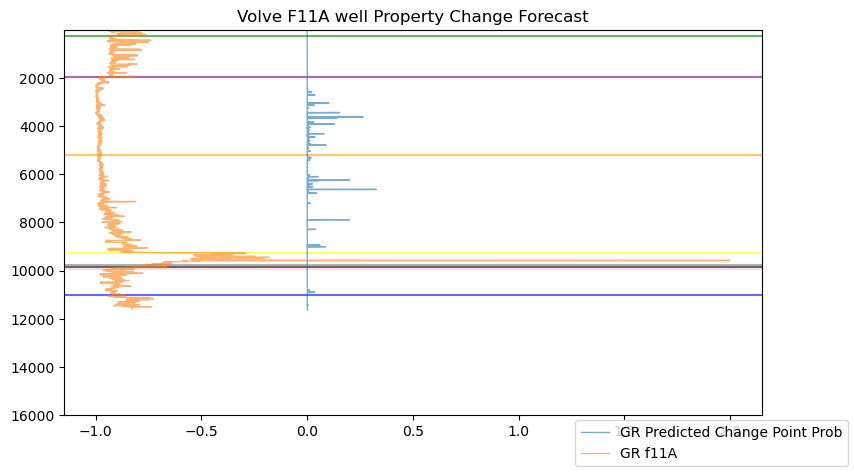

In [86]:
import matplotlib as mpl
#cmap = mpl.colormaps['']
fig, ax = plt.subplots(1, figsize=(9,5))
#plt.figure(figsize=(10,15))
ax.set_ylim(16000)
#ax.set_xlim(25)
f11A_top10 = f11A_tops*10-26000 #25400
k=0
for i in f11A_top10:
    ax.axhline(i, alpha=0.6, color=f11A_color[k])#, label=f11A_FM[k])
    #print(k)
    k=k+1
#ax.plot(np.sum(f11A_probmatrix, axis=1), np.arange(len(f11A_probmatrix)), linewidth=1, alpha=.6, label='MD Combined' )
#ax.plot(np.sum(f11A_probmatrixNPHI, axis=1)+3.2, np.arange(len(f11A_probmatrixNPHI)), linewidth=1, alpha=.6, label = 'MD NPHI' )
#plt.plot(np.sum(f11A_probmatrixRHOB, axis=1)+5.4, np.arange(len(f11A_probmatrixRHOB)), linewidth=1, alpha=.6, label = 'MD RHOB' )
#ax.plot(np.sum(f11A_probmatrixPEF, axis=1)+7.6, np.arange(len(f11A_probmatrixPEF)), linewidth=1, alpha=.6, label='MD PEF')
ax.plot(np.sum(f11A_probmatrixGR, axis=1), np.arange(len(f11A_probmatrixGR)), linewidth=1, alpha=.6, label = 'GR Predicted Change Point Prob' )
ax.plot(f11A_gr*3+ -1, np.arange(len(f11A_gr)) , linewidth=1, alpha=.6, label='GR f11A')
maxx = len(df_f11A)

plt.title('Volve F11A well Property Change Forecast')
#f11A_top10
#cmap = plt.colormaps('turbo')


fig.legend(loc='lower right')